In [1]:
import twint
# import nest_asyncio
# nest_asyncio.apply()
from googletrans import Translator
import emoji
import time
import re
from functools import partial
import string
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
warnings.simplefilter('ignore')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk import bigrams, trigrams
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, Phrases
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from nlp_indo_word import formal_map as formal
#from nlp_indo_word import formal_map # nlp_indo_word is a file I created that's filled with dictionaries I created here

In [ ]:
c2 = twint.Config()
c2.Search = "omnibus pemerintah"
c2.Limit = 20000
c2.Pandas = True
c2.Pandas_clean = True

twint.run.Search(c2)

tweets = twint.storage.panda.Tweets_df

In [2]:
tweets = pd.read_csv('tweets_20000.csv')

In [2]:
# for removing emoji

try:
    uchr = unichr  # Python 2
    import sys
    if sys.maxunicode == 0xffff:
        # narrow build, define alternative unichr encoding to surrogate pairs
        # as unichr(sys.maxunicode + 1) fails.
        def uchr(codepoint):
            return (
                unichr(codepoint) if codepoint <= sys.maxunicode else
                unichr(codepoint - 0x010000 >> 10 | 0xD800) +
                unichr(codepoint & 0x3FF | 0xDC00)
            )
except NameError:
    uchr = chr  # Python 3

# Unicode 11.0 Emoji Component map (deemed safe to remove)
_removable_emoji_components = (
    (0x20E3, 0xFE0F),             # combining enclosing keycap, VARIATION SELECTOR-16
    range(0x1F1E6, 0x1F1FF + 1),  # regional indicator symbol letter a..regional indicator symbol letter z
    range(0x1F3FB, 0x1F3FF + 1),  # light skin tone..dark skin tone
    range(0x1F9B0, 0x1F9B3 + 1),  # red-haired..white-haired
    range(0xE0020, 0xE007F + 1),  # tag space..cancel tag
)
emoji_components = re.compile(u'({})'.format(u'|'.join([
    re.escape(uchr(c)) for r in _removable_emoji_components for c in r])),
    flags=re.UNICODE)

In [3]:
# use cln first, then use remove_punc

stop = pd.read_csv('stoplist.csv')
stop_lst = stop['stop'].values.tolist()
stop_map = {i: '' for i in stop_lst}

abbr = pd.read_csv('singkatan-lib.csv') # from https://github.com/aliakbars/bilp
abbr_map = {i: j for i, j in zip(abbr['abbr'].values, abbr[' word'].values)}
abbr_map['sj'] = 'saja'
abbr_map['masy'] = 'masyarakat'
abbr_map['yoi'] = 'iya'

kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv') # from https://github.com/nasalsabila/kamus-alay
kamus_map = {i:j for i, j in zip(kamus_alay['slang'].values, kamus_alay['formal'].values)}
kamus_map['deg2an'] = 'gelisah'
kamus_map['x'] = 'x'


factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem(text):
    return stemmer.stem(text)

def remove_hashtags_(text):
    all_hasht = {i:'' for i in text.split() if i[0] == '#'}
    if len(all_hasht) == 0:
        return text
    else:
        return replace_word_dict(text, all_hasht)

def replace_word_dict(text, dictionary): # from https://stackoverflow.com/questions/51102201/replace-a-string-using-dictionary-regex
    pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in dictionary.keys()) + r')(?!\w)')
    result = pattern.sub(lambda x: dictionary[x.group()], text)
    return result

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punc(txt):
    return txt.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))).replace(' '*4, ' ').replace(' '*3, ' ').replace(' '*2, ' ').strip()



translator = Translator()

def translate(string):
    if len(string) == 0:
        return ''
    elif len(string) > 0:
        return translator.translate(string, src='en', dest='id').text

def extract_emojis(text):
    emojis = list(set(emoji.demojize(''.join(c for c in text if c in emoji.UNICODE_EMOJI), delimiters=('', ' ')).split()))
    if len(emojis) == 0:
        return ''
    elif len(emojis) != 0:
        emojis = ', '.join([re.sub('_', ' ', i) for i in emojis])
        return emojis


def extract_hasht(text):
    hasht = set([i for i in text.split() if i[0] == '#'])
    return ' '.join([split_hasht(i) for i in hasht])

def remove_username(string):
    return re.sub('@[^\s]+',' USER ', string)


# from https://stackoverflow.com/questions/44987406/regex-to-split-a-hashtag-into-words
def split_hasht(text):
    return " ".join([a for a in re.split('([A-Z][a-z]+)', text) if a][1:])


def remove_emoji(txt, remove_components=False):
    cleaned = emoji.get_emoji_regexp().sub(u'', txt)
    if remove_components:
        cleaned = emoji_components.sub(u'', cleaned)
    return cleaned

def remove_digits(txt):
    return re.sub("^\d+\s|\s\d+\s|\s\d+$", " angka ", txt)

def keep_alphanumeric(txt):
    return re.sub(r'[^A-Za-z0-9 ]+', '', txt)

def extract_double(txt):
    splt = txt.split()
    return ' '.join([i[:-1] if i[-1] == '2' else i for i in splt])

def clean_text(txt, remove_stopwords=True, debug=False):
    start = time.time()
    
    txt = remove_username(txt)
    txt = remove_hashtags_(txt)
    txt = remove_urls(txt)
    txt = remove_html(txt)
    txt = remove_emoji(txt)
    txt = remove_punc(txt)
    txt = keep_alphanumeric(txt)
    txt = remove_digits(txt)
    txt = txt.lower()
    txt = replace_word_dict(txt, kamus_map)
    txt = replace_word_dict(txt, abbr_map)
    txt = replace_word_dict(txt, formal)
    
    if remove_stopwords:
        txt = replace_word_dict(txt, stop_map)
    
    txt = extract_double(txt)
    
    txt = ' '.join(txt.split())
    if debug:
        print('finished, time: ', time.time()-start)


    return txt

In [45]:
formal = {}
formal['kopit'] = 'sakit'
formal['korona'] = 'sakit'
formal['corona'] = 'sakit'
formal['covid19'] = 'sakit'
formal['covid-19'] = 'sakit'
formal['enggak'] = 'tidak'
formal['engga'] = 'tidak'
formal['ga'] = 'tidak'
formal['g'] = 'tidak'
formal['aja'] = 'saja'
formal['pengin'] = 'ingin'
formal['pengen'] = 'ingin'
formal['yuk'] = 'ayo'
formal['kangen'] = 'rindu'
formal['kesini'] = 'sini'
formal['kesitu'] = 'sana'
formal['disini'] = 'sini'
formal['kesana'] = 'sana'
formal['situ'] = 'sana'
formal['cewek'] = 'perempuan'
formal['cowok'] = 'pria'
formal['laki'] = 'pria'
formal['mudah-mudahan'] = 'semoga'
formal['sih'] = 'memang'
formal['banget'] = 'sangat'
formal['mau'] = 'ingin'
formal['ku'] = 'aku'
formal['kocak'] = 'lucu'
formal['asyik'] = 'senang'
formal['asik'] = 'senang'
formal['kalo'] = 'jika'
formal['kalau'] = 'jika'
formal['tau'] = 'mengerti'
formal['dek'] = 'adik'
formal['adek'] = 'adik'
formal['bang'] = 'saudara'
formal['abang'] = 'saudara'
formal['kak'] = 'saudara'
formal['ntab'] = 'bagus'
formal['mantab'] = 'bagus'
formal['mantap'] = 'bagus'
formal['aduh'] = 'sakit'
formal['tuh'] = 'itu'
formal['tu'] = 'itu'
formal['ni'] = 'ni'
formal['nih'] = 'ini'
formal['gue'] = 'aku'
formal['gua'] = 'aku'
formal['melulu'] = 'terus'
formal['allah'] = 'tuhan'
formal['alloh'] = 'tuhan'
formal['yesus'] = 'tuhan'
formal['kristus'] = 'tuhan'
formal['bego'] = 'bodoh'
formal['tolol'] = 'bodoh'
formal['goblok'] = 'bodoh'
formal['lu'] = 'kamu'
formal['luh'] = 'kamu'
formal['elu'] = 'kamu'
formal['lo'] = 'kamu'
formal['loe'] = 'kamu'
formal['tak'] = 'tidak'
formal['liat'] = 'lihat'
formal['nengok'] = 'lihat'
formal['tengok'] = 'lihat'
formal['menengok'] = 'lihat'
formal['amit-amit'] = 'jijik'
formal['hoki'] = 'beruntung'
formal['alhamdulillah'] = 'syukur'
formal['astagfirullah'] = 'astaga'
formal['begini'] = 'ini'
formal['gini'] = 'ini'
formal['beginian'] = 'ini'
formal['ridho'] = 'berkat'
formal['ridha'] = 'berkat'
formal['anjir'] = 'kaget'
formal['anjay'] = 'kaget'
formal['memandang'] = 'lihat'
formal['mandang'] = 'lihat'
formal['hayo'] = 'ayo'
formal['asu'] = 'anjing'
formal['selo'] = 'santai'
formal['selow'] = 'santai'
formal['slow'] = 'santai'
formal['kayak'] = 'seperti'
formal['muka'] = 'wajah'
formal['bikin'] = 'buat'
formal['abal'] = 'palsu'
formal['moga'] = 'semoga'
formal['bro'] = 'teman'
formal['bray'] = 'teman'
formal['cuy'] = 'teman'
formal['coy'] = 'teman'
formal['kawatir'] = 'khawatir'
formal['adem'] = 'enak'
formal['aamiin'] = 'amin'
formal['amien'] = 'amin'
formal['amiin'] =  'amin'
formal['aamin'] = 'amin'
formal['amiiin'] = 'amin'
formal['kt'] = 'kita'
formal['kta'] = 'kita'
formal['dy'] = 'dia'
formal['doi'] = 'dia'
formal['km'] = 'kamu'

In [461]:
tweets['emojis_en'] = tweets['tweet'].apply(extract_emojis)

In [4]:
df = pd.read_csv('tw_20k_w_emoji.csv') # this is the csv created after i extracted emojis, converted them to text, and translated them to 'id'

In [5]:
def preprocess_df(df, stem_words=False, remove_stopwords=True, output='tokenized', debug=False):
    start = time.time()
    clean = partial(clean_text, remove_stopwords=remove_stopwords)
    df['hashtags_splt'] = df['tweet'].apply(extract_hasht) # this function extracted all the hashtags and separated them into words
    df_compact = df[['tweet', 'emojis', 'hashtags_splt']]
    df_compact['emojis'].fillna('', inplace=True)
    df_compact['tweet_'] = df_compact.apply(lambda x: ' '.join(x.values.tolist()), axis=1) # joining the converted emojis and split hashtags into the tweet
    df_compact['tweet_cln'] = df_compact['tweet_'].apply(clean)
    
    if stem_words:
        df['tweet_cln'] = df['tweet_cln'].apply(stem)
    
    df_compact['tweet_cln_tokenized'] = df_compact['tweet_cln'].apply(word_tokenize)
    df_compact.drop_duplicates(subset=['tweet_cln'], inplace=True)
    
    if debug:
        print(time.time() - start)
        
    if output == 'clean_tokenized':
        return df_compact['tweet_cln_tokenized'].values
    elif output == 'clean_untokenized':
        return df_compact['tweet_cln'].values
    elif output == 'raw':
        return df_compact['tweet'].values

In [ ]:
cln = preprocess_df(df, output='clean_untokenized')
cln_tokenized = preprocess_df(df, output='clean_tokenized')

In [ ]:
# w2v models from https://www.kaggle.com/ilhamfp31/ukara-building-word2vec-100-indonesia?select=idwiki_word2vec_100.model

model = Word2Vec.load('w2v/idwiki_word2vec_100.model')
print(len(model.wv.vocab))
model.build_vocab(cln_tokenized, update=True)
model.train(cln_tokenized, total_examples=len(cln_tokenized), epochs=1)
model.wv.init_sims(replace=False)
print(len(model.wv.vocab))

In [76]:
all_tweets = [j for i in cln_tokenized for j in i]

print('Total vocabulary: ', len(set(all_tweets)))

Total vocabulary:  20676


After cleaning the tweets, there are now 20.676 unique words in the scraped tweets.

Text(0.5, 1.0, 'Most frequent unigrams')

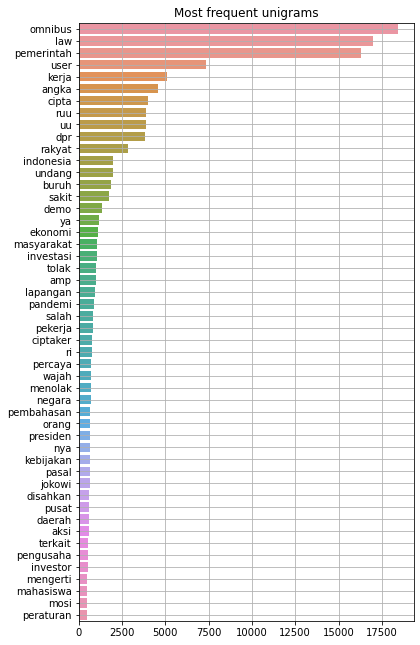

In [83]:
ug = [j for i in cln_tokenized for j in i]
count = Counter(ug)
ug_freq = dict(count.most_common(n=50))

fig, ax = plt.subplots(figsize=(6, 11))
sns.barplot(y=list(ug_freq.keys()), x=list(ug_freq.values()))
plt.grid()
plt.title('Most frequent unigrams')

Text(0.5, 1.0, 'Most frequent bigrams')

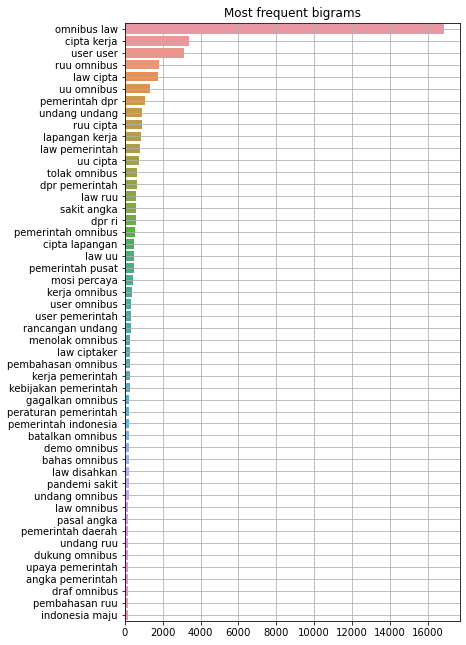

In [86]:
bg = [list(bigrams(i)) for i in cln_tokenized]

bg_melt = [' '.join(i) for j in bg for i in j]

count = Counter(bg_melt)
bg_freq = dict(count.most_common(n=50))
fig, ax = plt.subplots(figsize=(6, 11))
sns.barplot(y=list(bg_freq.keys()), x=list(bg_freq.values()))
plt.grid()
plt.title('Most frequent bigrams')

Text(0.5, 1.0, 'Most frequent trigrams')

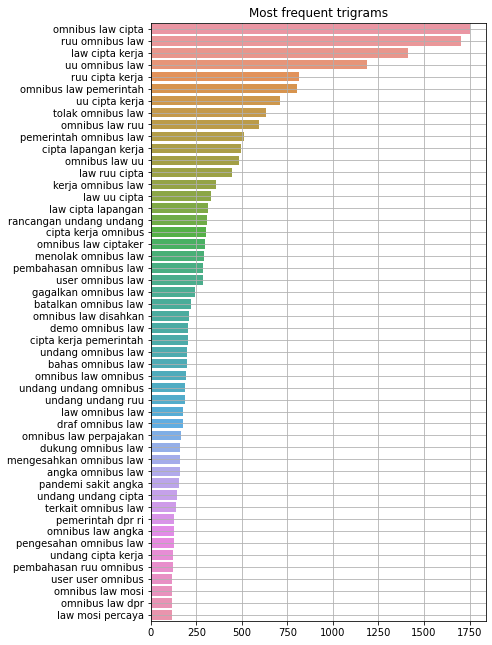

In [88]:
tg = [list(trigrams(i)) for i in cln_tokenized]

tg_melt = [' '.join(i) for j in tg for i in j]

count = Counter(tg_melt)
tg_freq = dict(count.most_common(n=51))
fig, ax = plt.subplots(figsize=(6, 11))
sns.barplot(y=list(tg_freq.keys())[1:], x=list(tg_freq.values())[1:])
plt.grid()
plt.title('Most frequent trigrams')

In [ ]:
def vectorizer_2(line, normalized=False): 
    filt = lambda word: model.wv.vocab.get(word, None) is not None
    line = list(filter(filt, line))
    words = [model[i] for i in line]
    if normalized:
        words = [model.wv.vectors_norm[word_indices[i]] for i in line]
    if words:
        words = np.asarray(words)
        return np.mean(words)
    elif not words:
        return None

In [ ]:
word_indices = {j:i for i, j in enumerate(model.wv.index2word)}

def vectorizer_1(line, normalized=False): 
    filt = lambda word: model.wv.vocab.get(word, None) is not None
    line = list(filter(filt, line))
    words = [model[i] for i in line]
    if normalized:
        words = [model.wv.vectors_norm[word_indices[i]] for i in line]
    if words: 
        words = np.asarray(words)
        min_vec = words.min(axis=0)
        max_vec = words.max(axis=0)
        return np.concatenate((min_vec, max_vec))
    elif not words:
        return None
    
def vectorize_series(series, normalized=False):
    return [vectorizer_1(i, normalized=normalized) for i in series]

In [30]:
embed = vectorize_series(cln_tokenized)
embed_norm = vectorize_series(cln_tokenized, normalized=True)

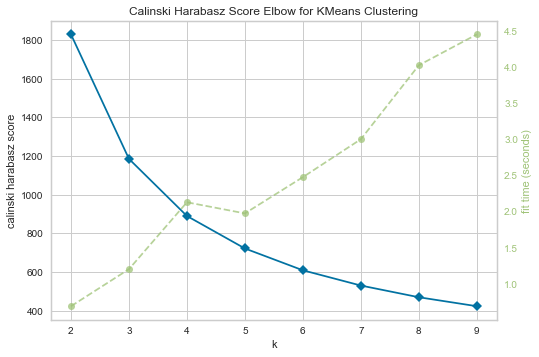

In [21]:
model1 = KMeans(random_state=22)

kmean_vis = KElbowVisualizer(model1, k=(2,10), metric='calinski_harabasz')
kmean_vis.fit(embed_norm)
kmean_vis.show()

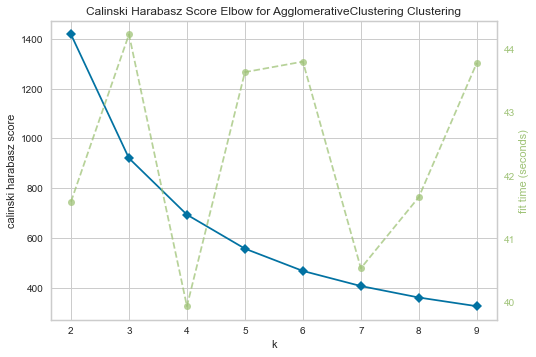

In [22]:
model2 = AgglomerativeClustering()

hac_vis = KElbowVisualizer(model2, k=(2,10), metric='calinski_harabasz')
hac_vis.fit(embed_norm)
hac_vis.show()

In [31]:
kmeans = KMeans(n_clusters=2, random_state=22)
hac = AgglomerativeClustering(n_clusters=2)

kmeans.fit(embed_norm)
hac.fit(embed_norm)

km_labels = kmeans.labels_
hac_labels = hac.labels_

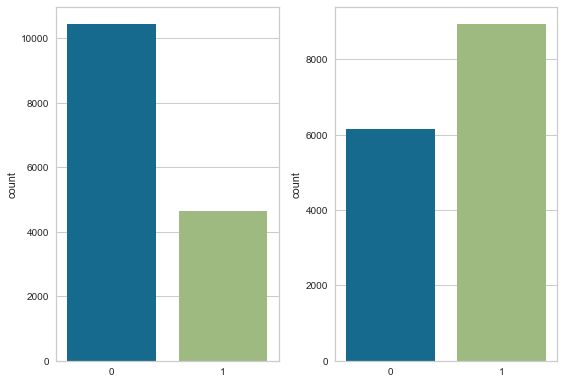

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

for i, j in zip([km_labels, hac_labels], [ax1, ax2]):
    g = sns.countplot(i, ax=j)
plt.tight_layout()

Count of labels (clusters) assigned to the tweets: K-Means (left), Hierarchical Agglomerative Clustering/HAC (right)

In [32]:
tweets_labeled = pd.concat([pd.Series(preprocess_df(df, output='raw')), pd.Series(km_labels), pd.Series(hac_labels)], axis=1)
tweets_labeled.columns = ['tweet', 'label (KMeans)', 'label (HAC)']

In [33]:
tweets_labeled.to_csv('tweets_labeled.csv')

In [22]:
tweets_labeled.values[-200:]

array([['@WikiDPR #Baleg Dr. Refly Harun : saya membayangkan nanti setelah adanya omnibus law itu ada juga peraturan pemerintah yang bersifat omnibus,  jangan-jangan nanti menteri juga mengeluarkan peraturan yang bersifat omnibus yaitu yang mencakup semua peraturan2 menteri sebelumnya',
        1, 0],
       ['Refly Harun Usul Peraturan Pemerintah dan Perpres Juga Diberlakukan Omnibus Law  https://t.co/9etank4bRJ',
        0, 1],
       ['Pemerintah Kejar Pajak Google, Facebook, dan Netflix dengan "Omnibus Law"  https://t.co/gHkkCIT7OR',
        0, 1],
       ['PSHK mendorong pemerintah dan legislator untuk melibatkan masyarakat luas dalam pembentukan undang-undang omnibus law.  https://t.co/aDH4FuLUPt',
        0, 0],
       ['agar ada makna, maka omnibus law tsb di berikan maksud dan tujuan, sekalipun materi nya "memperbaiki" berbagai UU yg telah ada.  masih tetap boleh? boleh lah, sepanjang DPR dan Pemerintah sepakat utk menjadikan nya UU.',
        0, 0],
       ['"Pendekatan omnib

In [20]:
tweets_labeled.head()

,tweet,label (KMeans),label (HAC)
0,@ikayulianip Memperlancar pembahasan uu omnibu...,0,1
1,UU Omnibus Law sudah dimenangkan oleh pemerint...,1,0
2,@saddburryy jadi menurut anda apa urhensi peme...,0,0
3,ada niat bagus dari Jokowi dengan adanya UU Om...,1,0
4,Saya melihat di sini ada niat bagus dari Presi...,1,0


In [21]:
tweets_labeled[tweets_labeled['label (KMeans)'] == tweets_labeled['label (HAC)']].shape[0]

2206

Only 2206 (out of ~15000 tweets) have similar labels. It could mean that the the clustering algorithms used kinda have an agreement over which tweet to include as which category, but the labels are just reversed.

All in all, the combination of vectorizing the tweets using Word2Vec and clustering don't seem to be working out so well. Most likely, the culprit is the embedding that couldn't capture enough information that can be used by the clustering algorithms, and even if it's not, I should still try different (and more powerful) embeddings, such as BERT, fasttext, or FlairEmbedding. It also could be the case that the tweets contains too much noise that maybe even the most powerful embedding won't be able to distill informations contained in them.